In [1]:
import torch
from torch import nn
import os
from pathlib import Path
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
device

'cuda'

In [3]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:

# Setup path to data folder
data_path = Path("data/")

walk_through_dir(data_path)


There are 11 directories and 0 images in 'data'.
There are 0 directories and 38 images in 'data\A&B50'.
There are 0 directories and 31 images in 'data\A&C&B10'.
There are 0 directories and 42 images in 'data\A&C&B30'.
There are 0 directories and 31 images in 'data\A&C10'.
There are 0 directories and 38 images in 'data\A&C30'.
There are 0 directories and 34 images in 'data\A10'.
There are 0 directories and 37 images in 'data\A30'.
There are 0 directories and 35 images in 'data\A50'.
There are 0 directories and 28 images in 'data\Fan'.
There are 0 directories and 25 images in 'data\Noload'.
There are 0 directories and 30 images in 'data\Rotor-0'.


In [5]:
# Setup path for target directory
target_directory = data_path 
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(data_path ))])
print(f"Class names found: {class_names_found}")

Target directory: data
Class names found: ['A&B50', 'A&C&B10', 'A&C&B30', 'A&C10', 'A&C30', 'A10', 'A30', 'A50', 'Fan', 'Noload', 'Rotor-0']


In [6]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
  
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [7]:
find_classes(data_path)

(['A&B50',
  'A&C&B10',
  'A&C&B30',
  'A&C10',
  'A&C30',
  'A10',
  'A30',
  'A50',
  'Fan',
  'Noload',
  'Rotor-0'],
 {'A&B50': 0,
  'A&C&B10': 1,
  'A&C&B30': 2,
  'A&C10': 3,
  'A&C30': 4,
  'A10': 5,
  'A30': 6,
  'A50': 7,
  'Fan': 8,
  'Noload': 9,
  'Rotor-0': 10})

In [8]:
from torchvision.datasets import VisionDataset

class ThermicMotorsImagesDataset(VisionDataset):
    def __init__(self, root: str, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        # Get class names and mapping
        self.classes, self.class_to_idx = find_classes(root)

        # Collect image paths and corresponding labels
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(root, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)
    
    def load_image(self, path: str) -> Image.Image:
        """Loads an image from a given path."""
        return Image.open(path).convert("RGB")

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = self.load_image(img_path)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [9]:
thermic_transformer=transforms.Compose([
    transforms.Resize((128, 128)),  # a bit more detail preserved
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # simulate noise in temp readings
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize to [-1,1] (optional)
])


In [10]:
fsl_dataset = ThermicMotorsImagesDataset(
    root=data_path,
    transform=thermic_transformer
)
len(fsl_dataset), len(fsl_dataset.classes), fsl_dataset.class_to_idx, fsl_dataset[0][0].shape, fsl_dataset[0][1] # (number of images, number of classes, class_to_idx mapping, image shape, label)

(369,
 11,
 {'A&B50': 0,
  'A&C&B10': 1,
  'A&C&B30': 2,
  'A&C10': 3,
  'A&C30': 4,
  'A10': 5,
  'A30': 6,
  'A50': 7,
  'Fan': 8,
  'Noload': 9,
  'Rotor-0': 10},
 torch.Size([3, 128, 128]),
 0)

In [ ]:
from torch.utils.data import Sampler
from collections import defaultdict
import random

class EpisodicSampler(Sampler):
    def __init__(self, labels, n_way, k_shot, q_query, num_episodes):
        """
        Few-Shot Episodic Sampler

        Args:
            labels (List[int]): List of all labels in dataset (same order as dataset indices)
            n_way (int): Number of classes per episode
            k_shot (int): Number of support samples per class
            q_query (int): Number of query samples per class
            num_episodes (int): How many episodes per epoch
        """
        self.labels = labels
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.num_episodes = num_episodes

        self.class_to_indices = self._build_class_index()

    def _build_class_index(self):
        class_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            class_to_indices[label].append(idx)
        return class_to_indices

    def __len__(self):
        return self.num_episodes

    def __iter__(self):
        for _ in range(self.num_episodes):
            selected_classes = random.sample(list(self.class_to_indices.keys()), self.n_way)

            episode_indices = []

            for cls in selected_classes:
                indices = random.sample(self.class_to_indices[cls], self.k_shot + self.q_query)
                episode_indices.extend(indices)

            yield episode_indices


In [ ]:
sampler = EpisodicSampler(
    labels=fsl_dataset.labels,
    n_way=5,
    k_shot=1,
    q_query=5,
    num_episodes=100
)

loader = torch.utils.data.DataLoader(
    fsl_dataset,
    batch_sampler=sampler,
    num_workers= os.cpu_count() # 
)


In [13]:
import matplotlib.pyplot as plt
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))
    
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # Denormalize the image
        targ_image = targ_image * 0.5 + 0.5
        
        # Adjust tensor shape for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0).numpy()
        
        # Handle grayscale images
        if targ_image_adjust.shape[-1] == 1:
            targ_image_adjust = targ_image_adjust.squeeze(-1)
        
        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust, cmap='gray' if targ_image_adjust.ndim == 2 else None)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)

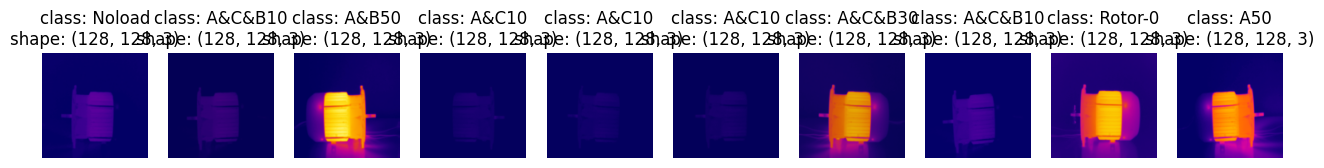

In [14]:
display_random_images(fsl_dataset, classes=fsl_dataset.classes, n=10, display_shape=True, seed=42)
# 

In [15]:
import torchvision

# Create model weights and transforms
model_weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
transforms = model_weights.transforms()

# Setup model
model = torchvision.models.resnet18(weights=model_weights)


In [16]:
from torchinfo import summary
summary(model, input_size=(1,3, 128, 128), device=device) 

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 64, 64]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─ReLU: 1-3                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
│

In [17]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [18]:
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),  # Add dropout to prevent overfitting
    torch.nn.Linear(in_features=512,       # ResNet18 output feature size (512)
                    out_features=len(fsl_dataset),  # Number of output classes
                    bias=True)
)


In [19]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 369]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer) -> Tuple[float, float]:
    """Train step for a single episode."""
    # Put model in train mode
    model.train()

    # Setup train loss and accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader for episodic training batches
    for batch, (support_images, support_labels, query_images, query_labels) in enumerate(dataloader):
        # Forward pass: support images to get predictions
        support_pred = model(support_images)

        # Calculate support loss
        loss = loss_fn(support_pred, support_labels)
        train_loss += loss.item()

        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.inference_mode():
        # Calculate accuracy on query set
        query_pred = model(query_images)
        query_pred_class = torch.argmax(query_pred, dim=1)
        train_acc += (query_pred_class == query_labels).sum().item() / len(query_labels)
    
    # Adjust metrics to get average loss and accuracy
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int) -> Dict[str, List]:
    """Training function for Few-Shot Learning model."""
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": []
    }

    # Loop through training for the number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

    # Return the filled results at the end of the epochs
    return results
